# Aventica
# Тестовое задание на позицию ML Engineer
## Соискатель Николай Осипов
## Обучение модели

Обучение модели проводилось в окружении Google Colab GPU. Для обучения используется библиотека PyTorch, для сохранения обученной модели используется ONNX. Далее по ходу решения будут представлены дополнительные комментарии.

# Настройка окружения

In [ ]:
!pip install onnxruntime==1.14.1 -q
!pip install onnx==1.13.1 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 95.1 MB/s eta 0:00:00


In [ ]:
import os
import copy
import random
from typing import List, Tuple, Callable

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim import Optimizer
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm

In [ ]:
def set_seed(seed: int) -> None:
    """Фунция фиксирующая зерно датчика случайных чисел.
    Parameters
    ----------
    seed: int, число для датчика.

    Returns
    -------
    None - функция ничего не возвращает.
    
    """
    
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

# Функции необходимые для обучения

In [ ]:
def train(
    model: nn.Module, 
    data_loader: DataLoader, 
    optimizer: Optimizer, 
    loss_fn: Callable,
    device: torch.device
) -> Tuple[float, float]:

    """
    Функция для тренировки модели. Возвращает значение функции потерь и Accuracy.

    Paramaters
    ----------
    model : nn.Module
        Модель PyTorch, которую нужно обучить.
    data_loader : DataLoader
        DataLoader, который загружает тренировочный набор данных.
    optimizer: Optiimizer
        Оптимизатор, например Adam, SGD и тд.
    loss_fn : Callable
        Функция потерь, используемая для вычисления 
        потерь между предсказаниями модели и правильными метками.
    device : torch.device
        Устройство на котором будет проводиться обучение.

    Returns
    -------
    Tuple[float, float]
        Кортеж, содержащий среднее значение функции потерь и Accuracy 
        на обучающем наборе данных.
    """

    model.train()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(data_loader, desc='Train'):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = loss_fn(output, y)
        loss.backward()
        total_loss += loss.item()
        optimizer.step()

        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    return total_loss / len(data_loader), correct / total


@torch.inference_mode()
def evaluate(
    model: nn.Module, 
    data_loader: DataLoader, 
    loss_fn: Callable,
    device: torch.device
) -> Tuple[float, float]:
    """
    Функция вычисляет точность модели PyTorch на валидационном наборе данных.

    Parameters
    ----------
    model : nn.Module
        Модель PyTorch, которую нужно оценить.
    data_loader : DataLoader
        DataLoader, который загружает валидационный набор данных.
    loss_fn : Callable
        Функция потерь, используемая для вычисления потерь 
        между предсказаниями модели и правильными метками.
    device : torch.device
        Устройство на котором будет проводиться обучение.

    Returns
    -------
    Tuple[float, float]
        Кортеж, содержащий среднюю потерю и Accuracy 
        на валидационном наборе данных.
        
    """

    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(data_loader, desc='Evaluate'):
        x, y = x.to(device), y.to(device)
        output = model(x)
        loss = loss_fn(output, y)
        total_loss += loss.item()

        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    return total_loss / len(data_loader), correct / total


def get_plot(
    train_list: List[float], 
    valid_list: List[float], 
    title: str, 
    postfix: str
) -> None:
    """
    Функция для построения графика метрики на тренировке и валидации модели.

    Parameters
    ----------
    train_loss : List[float]
        Список значений метрики на тренировочном наборе данных для каждой эпохи.
    valid_loss : List[float]
        Список значений метрики на валидационном наборе данных для каждой эпохи.
    title: str
        Заголовок графика.
    postfix: str
        Постфикс заголовка графика.
    
    Returns
    -------
    None - функция ничего не возвращает.
    """
    plt.figure(figsize=(12, 6))
    plt.title(f"{title} {postfix}")
    plt.plot(train_list, label=f"Train {postfix}")
    plt.plot(valid_list, label=f"Valid {postfix}")
    plt.legend()
    plt.grid()
    plt.show()
    

def plot_stats(
    train_loss: List[float],
    valid_loss: List[float],
    train_accuracy: List[float],
    valid_accuracy: List[float],
    title: str,
) -> None:
    """
    Функция для построения графиков функции потерь и Accuracy 
    на тренировке и валидации модели.

    Parameters
    ----------
    train_loss : List[float]
        Список значений функции потерь на тренировочном наборе данных для каждой эпохи.
    valid_loss : List[float]
        Список значений функции потерь на валидационном наборе данных для каждой эпохи.
    train_accuracy : List[float]
        Список значений Accuracy на тренировочном наборе данных для каждой эпохи.
    valid_accuracy : List[float]
        Список значений Accuracy на валидационном наборе данных для каждой эпохи.
    title : str
        Заголовок графика.

    Returns
    -------
    None - функция ничего не возвразает
    """

    get_plot(train_loss, valid_loss, title, "loss")
    get_plot(train_accuracy, valid_accuracy, title, "accuracy")


def whole_train_valid_cycle(
    model: nn.Module, 
    train_loader: DataLoader, 
    valid_loader: DataLoader, 
    optimizer: Optimizer, 
    loss_fn: Callable,
    device: torch.device,
    n_epoch: int,
    threshold: float, 
    title: str
) -> None:
    """
    Функция для полного цикла обучения и валидации модели с выводом графиков.

    Parameters
    ----------
    model : nn.Module
        Модель нейронной сети для обучения.
    train_loader : DataLoader
        DataLoader для тренировочного набора данных.
    valid_loader : DataLoader
        DataLoader для валидационного набора данных.
    optimizer : Optimizer
        Оптимизатор для обучения модели.
    loss_fn : Callable
        Функция потерь, которая будет использоваться при обучении модели.
    device : torch.device
        Устройство на котором будет проводится обучение и валидация модели.
    n_epoch : int
        Количество эпох обучения. 
    threshold : float
        Значение метрики на валидационном наборе данных, при достижении которого обучение прекращается.
    title : str
        Заголовок графиков для отслеживания процесса обучения.

    Returns
    -------
    None - функция ничего не возвращает
    """

    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(n_epoch):
        train_loss, train_accuracy = train(model, train_loader, optimizer, loss_fn, device)
        valid_loss, valid_accuracy = evaluate(model, valid_loader, loss_fn, device)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output(wait=True)

        plot_stats(
            train_loss_history,
            valid_loss_history,
            train_accuracy_history,
            valid_accuracy_history,
            title,
        )

        if valid_accuracy >= threshold:
            break


# Обобщающая функция main

Основная функция для обучения. 
В ней фиксируется зерно датчика случайных чисел, загружается датасет MNIST, загружается модель.  
Зафиксировано количество эпох, но используется early stopping в виде остановки обучения по достижении определенного порога (threshold).   
Будем использовать оптимизатор Adam и CrossEntropyLoss как функцию потерь.  
По достижении порога, либо проходу по всем эпохам веса модели будут сохранены.

In [ ]:
def main(create_model: Callable, threshold: float, title: str="CNN") -> None:
    """
    Основная функция которая обучает нейронную сеть на датасете MNIST 
    и сохраняет веса модели.

    Parameters
    ----------
    create_model : Callable
        Функция, возвращающая созданную модель.
    threshold : float
        Значение точности на валидации, при достижении которой 
        обучение прерывается.
    title : str, optional (default="CNN")
        Название модели для графиков.

    Returns
    -------
    None - фунция ничего не возвращает.
    """

    set_seed(1)

    mnist_train = MNIST("mnist", train=True, download=True, transform=T.ToTensor())
    mnist_valid = MNIST("mnist", train=False, download=True, transform=T.ToTensor())

    train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
    valid_loader = DataLoader(mnist_valid, batch_size=64, shuffle=False)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = create_model().to(device)

    n_epoch = 100
    optimizer = Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()

    whole_train_valid_cycle(
        model=model, 
        train_loader=train_loader, 
        valid_loader=valid_loader, 
        optimizer=optimizer, 
        loss_fn=loss_fn, 
        device=device,
        n_epoch=n_epoch, 
        threshold=threshold, 
        title=title
    )

    torch.save(model.state_dict(), "model.pt")

# Архитектура модели

Архитектура модели основана на 7 сверточных слоях, пулинге, функции активации ReLU и классификаторе с полносвязными слоями в конце.

In [ ]:
class ConvNet(nn.Module):
    """
    Сверточная нейронная сеть для классификации изображений.
    """

    def __init__(self):
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU()

        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.conv5 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.relu5 = nn.ReLU()
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.relu6 = nn.ReLU()

        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv7 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=1)
        self.relu7 = nn.ReLU()

        self.out = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 10)
        )

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.relu4(x)

        x = self.maxpool2(x)

        x = self.conv5(x)
        x = self.relu5(x)
        x = self.conv6(x)
        x = self.relu6(x)

        x = self.maxpool2(x)

        x = self.conv7(x)
        x = self.relu7(x)

        x = self.out(x)   
        return x


def get_model():
    return ConvNet()

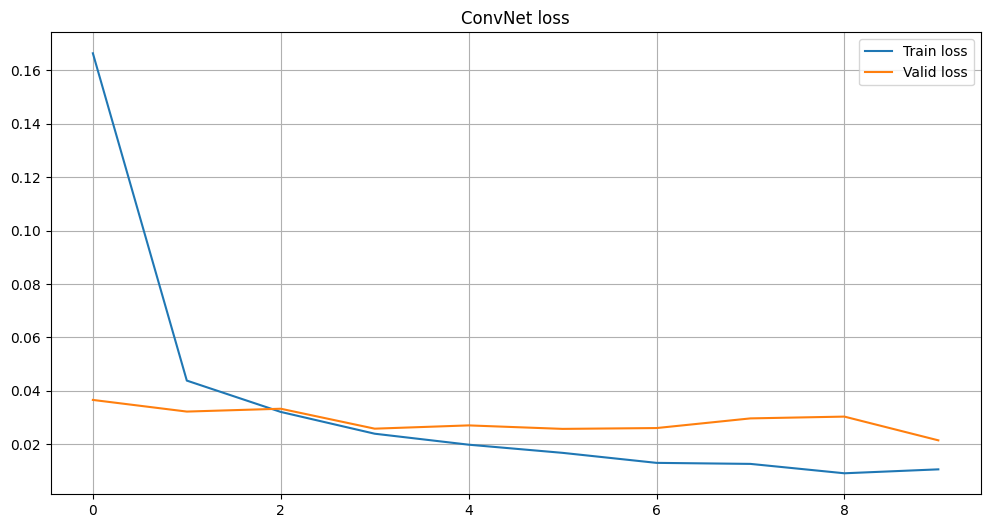

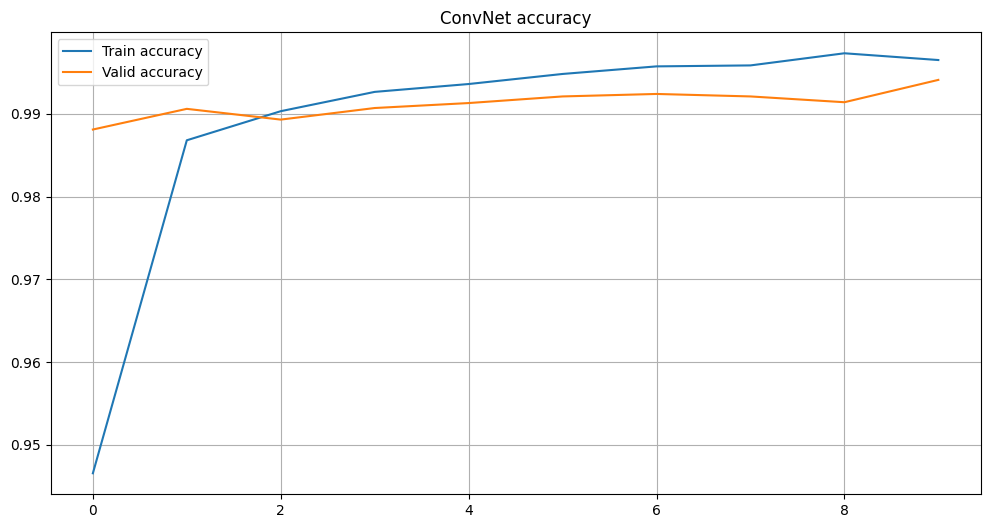

In [ ]:
main(get_model, threshold=0.993, title="ConvNet")

# ONNX и квантизация

Загрузим веса, проведем квантизацию и сравним качество моделей.

In [ ]:
import onnx
from onnxruntime.quantization import quantize_dynamic, QuantType
from onnxruntime import InferenceSession

In [ ]:
model = get_model()
model.load_state_dict(torch.load("model.pt"))

model_path = "model.onnx"
model_quant_path = "model.quant.onnx"
input_tensor = torch.randn((1, 1, 28, 28))

torch.onnx.export(
    model,
    input_tensor,
    model_path,
    export_params=True,
    opset_version=12,
    do_constant_folding=True,
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={
        "input": {0: "batch_size"},
        "output": {0: "batch_size"}
    }
)
model_quant = quantize_dynamic(model_path, model_quant_path, weight_type=QuantType.QUInt8)

============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



Проверка - корректно ли загружается модель.

In [ ]:
onnx_model = onnx.load(model_quant_path)
onnx.checker.check_model(onnx_model)

In [ ]:
def to_numpy(tensor: torch.tensor) -> np.ndarray:
    """
    Функция переводит tensor.torch в numpy.ndarray.
    """
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

Подготовка данных.

In [ ]:
mnist_valid = MNIST("mnist", train=False, download=True, transform=T.ToTensor())
valid_loader = DataLoader(mnist_valid, batch_size=1, shuffle=False)
device = torch.device("cpu")
loss_fn = nn.CrossEntropyLoss()

ONNX Runtime сессия.

In [ ]:
session = InferenceSession(model_quant_path)
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

Замерим точность обоих моделей.

In [ ]:
correct = 0

for x, y in tqdm(valid_loader, desc='Evaluate'):
    x, y = x.to(device), y.to(device)
    output = session.run([output_name], {input_name: to_numpy(x)})
    y_pred = np.argmax(output[0])
    correct += (y_pred == y.item())

accuracy_model_onnx = correct / len(valid_loader)
_, accuracy_model = evaluate(model, valid_loader, loss_fn, device)

Evaluate: 100%|██████████| 10000/10000 [02:03<00:00, 80.98it/s]


In [ ]:
print(
    f"Accuracy:",
    f"Исходная модель, fp32 = {accuracy_model}",
    f"Квантизированная модель ONNX, int8 = {accuracy_model_onnx}",
    sep="\n"
)

Accuracy:
Исходная модель, fp32 = 0.9941
Квантизированная модель ONNX, int8 = 0.9939


In [ ]:
def print_size_of_model(model_path, label=""):
    size = os.path.getsize(model_path)
    print(f"Модель: {label} \t Размер (MB): {size/1e6}")
    return size

f = print_size_of_model("model.pt", "fp32")
q = print_size_of_model(model_quant_path, "int8")
print(f"Размер меньше в {round(f / q, 2)}")

Модель: fp32 	 Размер (MB): 15.597767
Модель: int8 	 Размер (MB): 3.916391
Размер меньше в 3.98


Качество упало не сильно, но размер уменьшился почти в 4 раза. Будем использовать модель в формате ONNX.

# Выводы

01. Подготовлены классическе лупы для обучения и валидации моделей, которые можно переиспользовать в дальнейшем.
02. Построена и обучена архитектура сверточной нейронной сети с помощью библиотеки PyTorch.
03. Сеть выдает качество на валидации Accuracy = 0.994
04. Подготовлен onnx формат для инференса модели.

# Рекомендации

01. Доработать функции тренировки и обучения, чтобы можно было использовать любую метрику, а не только Accuracy.
02. Попробовать pruning.